# Hierarchical Window Clustering Approach to detecting Spiking Motifs

### This notebook overviews an appraoch to clustering spikes in a binary time-series data. 

The major steps are:
1. Generating synthetic data
2. Processing the data and clustering spikes that have correlated local neighborhoods.
3. Re-clustering the spikes based of the timing interval of the clsuter apearances.
4. Using the hungarian method to compare predicted and ground-truth labels
5. Check performance.

## Data Generation

In [112]:
'''
Model parameters
'''
import random
import numpy as np

M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 4 # hz
background_noise_fr = 0 # h

np.random.seed(41)

In [113]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [114]:
'''
Synthetic Data Generation
'''
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)
K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)

# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)
B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,0] = np.random.randint(0,999,(N,T+D))
A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b-1]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
debug = A_dense
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

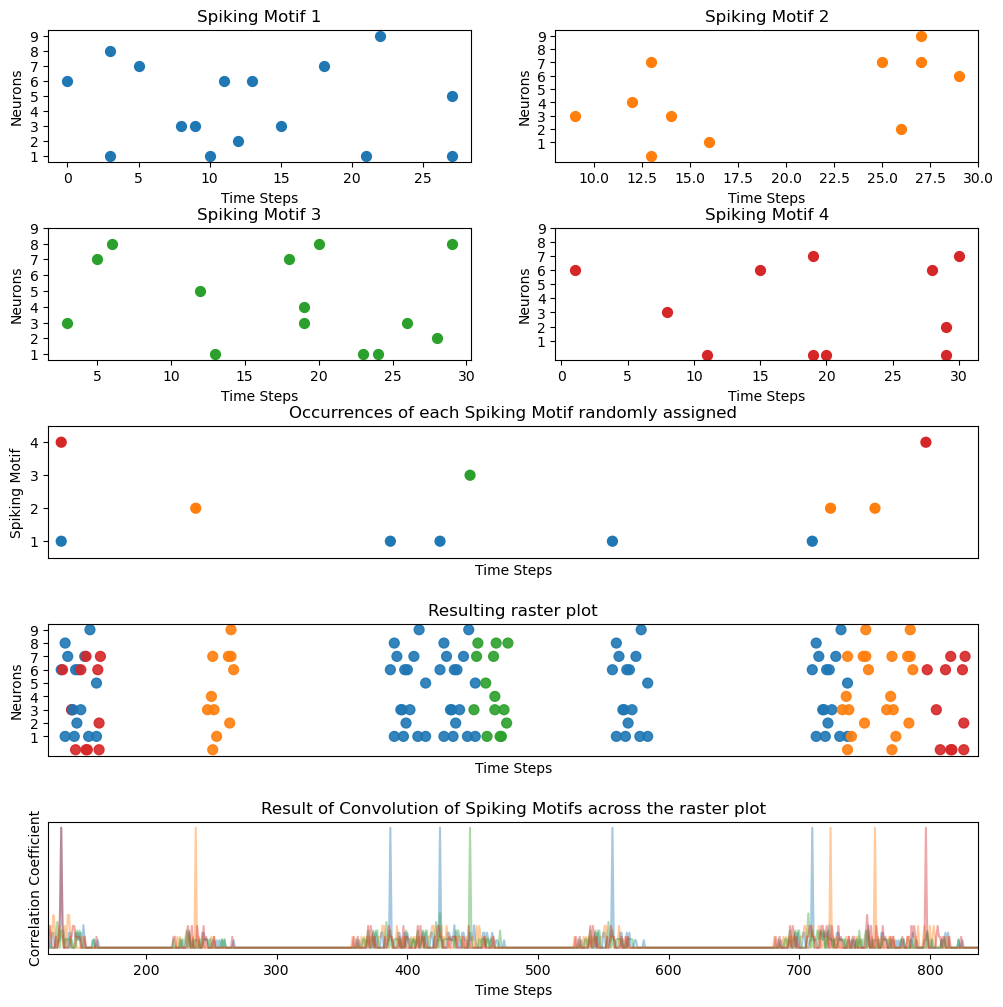

In [115]:
import matplotlib.ticker as ticker

fig, ax = plt.subplot_mosaic('AB;CD;EE;FF;GG', figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

s = 50

# Scatter plots for A, B, C, D
for i, k in enumerate(['A', 'B', 'C', 'D']):
    ax[k].scatter(K_sparse[1][K_sparse[2] == i+1], K_sparse[0][K_sparse[2] == i+1], c=palette[i+1], s=s)
    ax[k].set_title(f'Spiking Motif {i + 1}')  # Updated title for plots A, B, C, D
    ax[k].set_xlabel('Time Steps')
    ax[k].set_ylabel('Neurons')
    ax[k].set_yticks(range(1, N))

spiking_motif_data = [B_sparse[0][B_sparse[1] == i+1] for i in range(4)]  # Collect data for each Spiking Motif
ax['E'].scatter(B_sparse[1], B_sparse[0]-1, c=palette[B_sparse[0]], s=s)
ax['E'].set_title('Occurrences of each Spiking Motif randomly assigned')
ax['E'].set_xlabel('Time Steps')
ax['E'].set_ylabel('Spiking Motif')  # Updated y-axis label for plot E

# Set y-axis ticks and labels explicitly for Spiking Motifs 1 to 4
ax['E'].set_yticks(range(0, M))  # Set y-axis ticks for plot E to represent the four Spiking Motifs
ax['E'].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x) + 1}'))  # Map y-axis labels to display 1 through 4
ax['E'].set_ylim(-0.5, 3.5)  # Set y-axis limits to display only the ticks and labels for the existing values


# Scatter plot for F
ax['F'].scatter(A_sparse[1], A_sparse[0], c=palette[A_sparse[2]], alpha=0.9, s=s*4, marker='.')
ax['F'].set_title('Resulting raster plot')
ax['F'].set_xlabel('Time Steps')
ax['F'].set_ylabel('Neurons')  # Y-axis represents neurons, no need to update y-axis label
ax['F'].set_yticks(range(1, N))  # Set y-axis ticks for plot F to represent neurons

test = np.zeros((T,M))
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])

# Plot for G
[ax['G'].plot(test[:, i], color=palette[i+1], alpha=0.4) for i in range(M)]
ax['G'].set_title('Result of Convolution of Spiking Motifs across the raster plot')
ax['G'].set_xlabel('Time Steps')
ax['G'].set_ylabel('Correlation Coefficient')  # Updated y-axis label for plot G
ax['G'].set_yticks([])  # Remove y-axis ticks for plot G

# Set common x-axis from 0 to 1000 with padding
common_xlim = (min(A_sparse[1]), max(A_sparse[1]))
padding = 10
ax['E'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['F'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['G'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)

# Share x-axis for E, F, and G
ax['E'].sharex(ax['F'])
ax['G'].sharex(ax['F'])

# Hide x-axis ticks and labels for E and F
ax['E'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax['F'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()


This is the generated dataset that we will be working with. The lower panel shows the convolution of the the "Spiking Motifs" with the full raster plot. This convolution shows that by knowing the shape of the spiking motifs, the patterns can be robustly detected.

## Clustering 1

In [116]:
'''
Post-processing and clustering
'''

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Windowing the data
window_dim = (int(np.ceil(D/2)), N) # choosing a window to surround the spikes, this is a prediction but for now we will use the a priori depth D
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0]) # spikes closer to border will not be counted for simplicity
A_trunc = (A_sparse[0][valid_spikes],A_sparse[1][valid_spikes].copy(),A_sparse[2][valid_spikes].copy()) # creating a new "A_sparse" with only valid spikes
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2)) # creating a matrix of all of the windows surrounding every spike in the matrix
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
    
HDPs = []
sim_mats = []
# Set the cutoff value for clustering
cutoff = 1

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = []
for n in range(N):
    windows_n = windows[N_labels==n]
    if len(windows_n) > 1:
        x = np.zeros((len(windows_n),len(windows_n)))
        for i in range(windows_n.shape[0]):
            for j in range(windows_n.shape[0]):
                x[i,j] = np.sum(windows_n[i]*windows_n[j])/ min(np.sum(windows_n[i]),np.sum(windows_n[j]))
        sim_mats.append(x)
        dissimilarity = 1 - x
        if not np.all(dissimilarity == 0):
            HDPs.append(linkage(dissimilarity, method='complete'))
            clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))
    elif len(windows_n) == 1:
        clusters += [n*100]


clusters= np.array(clusters)

C:\Users\miles\AppData\Local\Temp\ipykernel_1676\2813406777.py:36: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDPs.append(linkage(dissimilarity, method='complete'))
C:\Users\miles\AppData\Local\Temp\ipykernel_1676\2813406777.py:37: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))


The above code computes the initial clusters for each spike. The steps are:
1. Creating a window centered around each spike that has the shape (NxD).
2. Comparing the similarity of each window row-wise (comparing each window in Neuron N to all other windows ONLY for neuron N).

If, for each spiking motif, there is no more than 1 spike per neuron, than the result will be a unique label for each motif. However, if a neuron fires multiple times within a motif then more clustering will need to be done to decipher the motifs. 
Each spike belongs to it's own cluster!

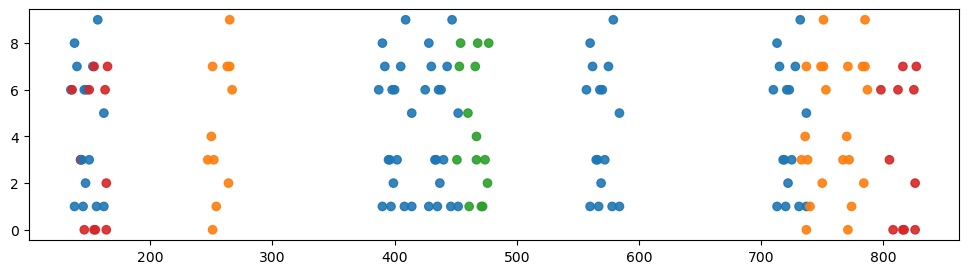

In [117]:
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=palette[A_sparse[2]],alpha=0.9)
plt.show()

Let's start with Neuron 9. Neuron 9 spikes at the presence of 2 spiking motifs (blue and green). 
Let's look at all of the windows generated for the spikes in Neuron 9...

A priori, we see that there are 5 spikes that belong to Spiking Motif 1 and 3 spikes from Spiking Motif 2. Since we know that these spikes are embedded in a motif, we can classify these spikes according to their local neighborhood. Let's play dumb and see what labels come out when using windows to classify the spikes, and then compare that to the ground truth afterwards

In [130]:
example=9
test = windows[N_labels==example]
print(len(test))
test = test.reshape((4,2, *test[0].shape))

8


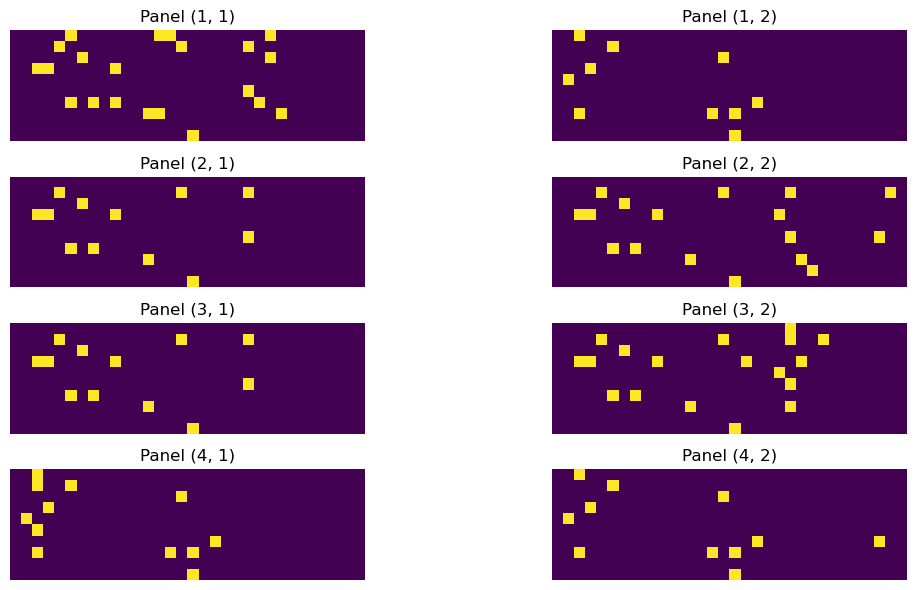

In [131]:
# Create a 2x4 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 6))

# Loop through each subplot and create a dummy imshow plot
for i in range(4):
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(test[i,j])
        ax.set_title(f'Panel ({i+1}, {j+1})')
        ax.axis('off')  # Turn off axis labels and ticks

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

To see if these windows have anything in common let's sum up the windows.

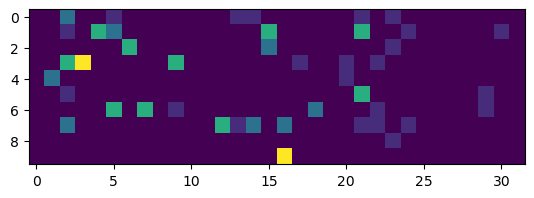

In [132]:
test = windows[N_labels==example]
plt.figure()
plt.imshow(np.sum(test,axis=0))

Looks like there is evidence of patterns embedded in some of the windows. To be clear, brighter pixels indicate that a spike occurs exactly at that pixel more frequently than dimmer pixels.

What happens when we create a dissimilarity matrix on the windows for Neuron 9?

In [134]:
if len(test) > 0:
    x = np.zeros((len(test),len(test)))
    for i in range(test.shape[0]):
        for j in range(test.shape[0]):
            x[i,j] = np.sum(test[i]*test[j])/ min(np.sum(test[i]),np.sum(test[j]))
    similarity = x
    dissimilarity = 1 - x
    clusters_test = list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))

C:\Users\miles\AppData\Local\Temp\ipykernel_1676\2732013442.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters_test = list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))


Text(0, 0.5, 'Spikes (0,...,8) for Neuron 9')

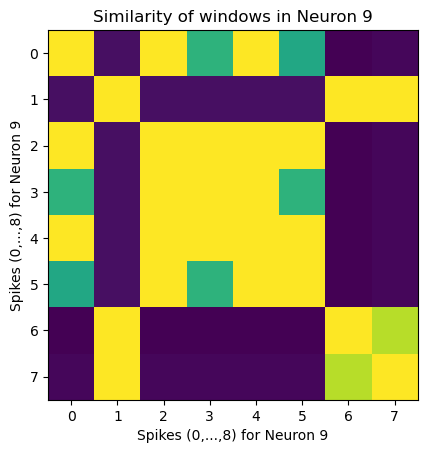

In [140]:
plt.figure()
plt.imshow(similarity)
plt.title('Similarity of windows in Neuron 9')
plt.xlabel('Spikes (0,...,8) for Neuron 9')
plt.ylabel('Spikes (0,...,8) for Neuron 9')

By definition, brighter squares in this matrix correspond to high similarity between spikes. A row or column containing multiple bright squares suggest that spikes are similar to each other.  
This matrix shows that spike 0 is similar to spikes 3 through 5. While spike 1 is similar to spikes 6 and 7.

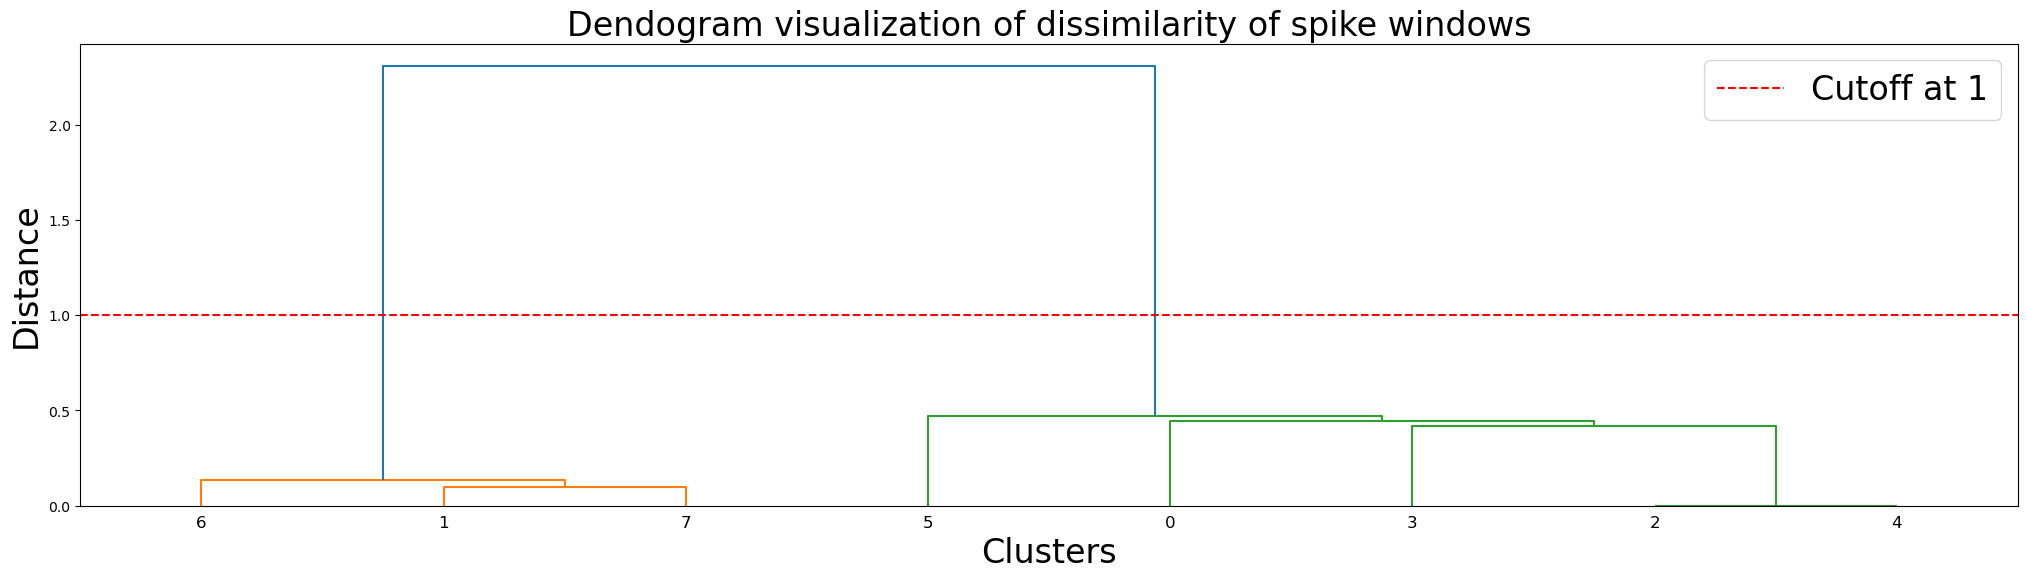

In [147]:
# Create the dendrogram plot
fig = plt.figure(figsize=(25, 6))
HDP = linkage(dissimilarity, method='complete')
dn = dendrogram(HDP)

# Add a horizontal line at the cutoff value of 1
plt.axhline(y=1, color='r', linestyle='--', label='Cutoff at 1')

# Add labels and legend
plt.title("Dendogram visualization of dissimilarity of spike windows", fontsize=24)
plt.ylabel('Distance', fontsize=24)
plt.xlabel('Clusters', fontsize=24)
plt.legend(fontsize=24)

plt.show()

So this method creates the following clusters:
- spikes [0,1,2,3,4,5,6,7]
- labels [2,1,2,2,2,2,1,1]

Let's compare this to the ground-truth:

In [152]:
A_sparse[2][A_sparse[0]==example]

array([1, 2, 1, 1, 1, 1, 2, 2], dtype=int64)

It was able to sperate the clusters perfectly!
Let's look at a more complicated example...

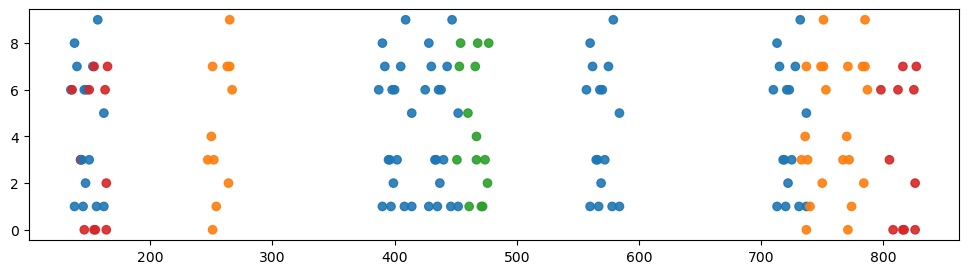

In [153]:
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=palette[A_sparse[2]],alpha=0.9)
plt.show()

Let's look at neuron 1 since there are 3 patterns with multiple spikes per pattern appearance.

In [160]:
example=1
test = windows[N_labels==example]
print(len(test))
test = test.reshape((13,2, *test[0].shape))

26


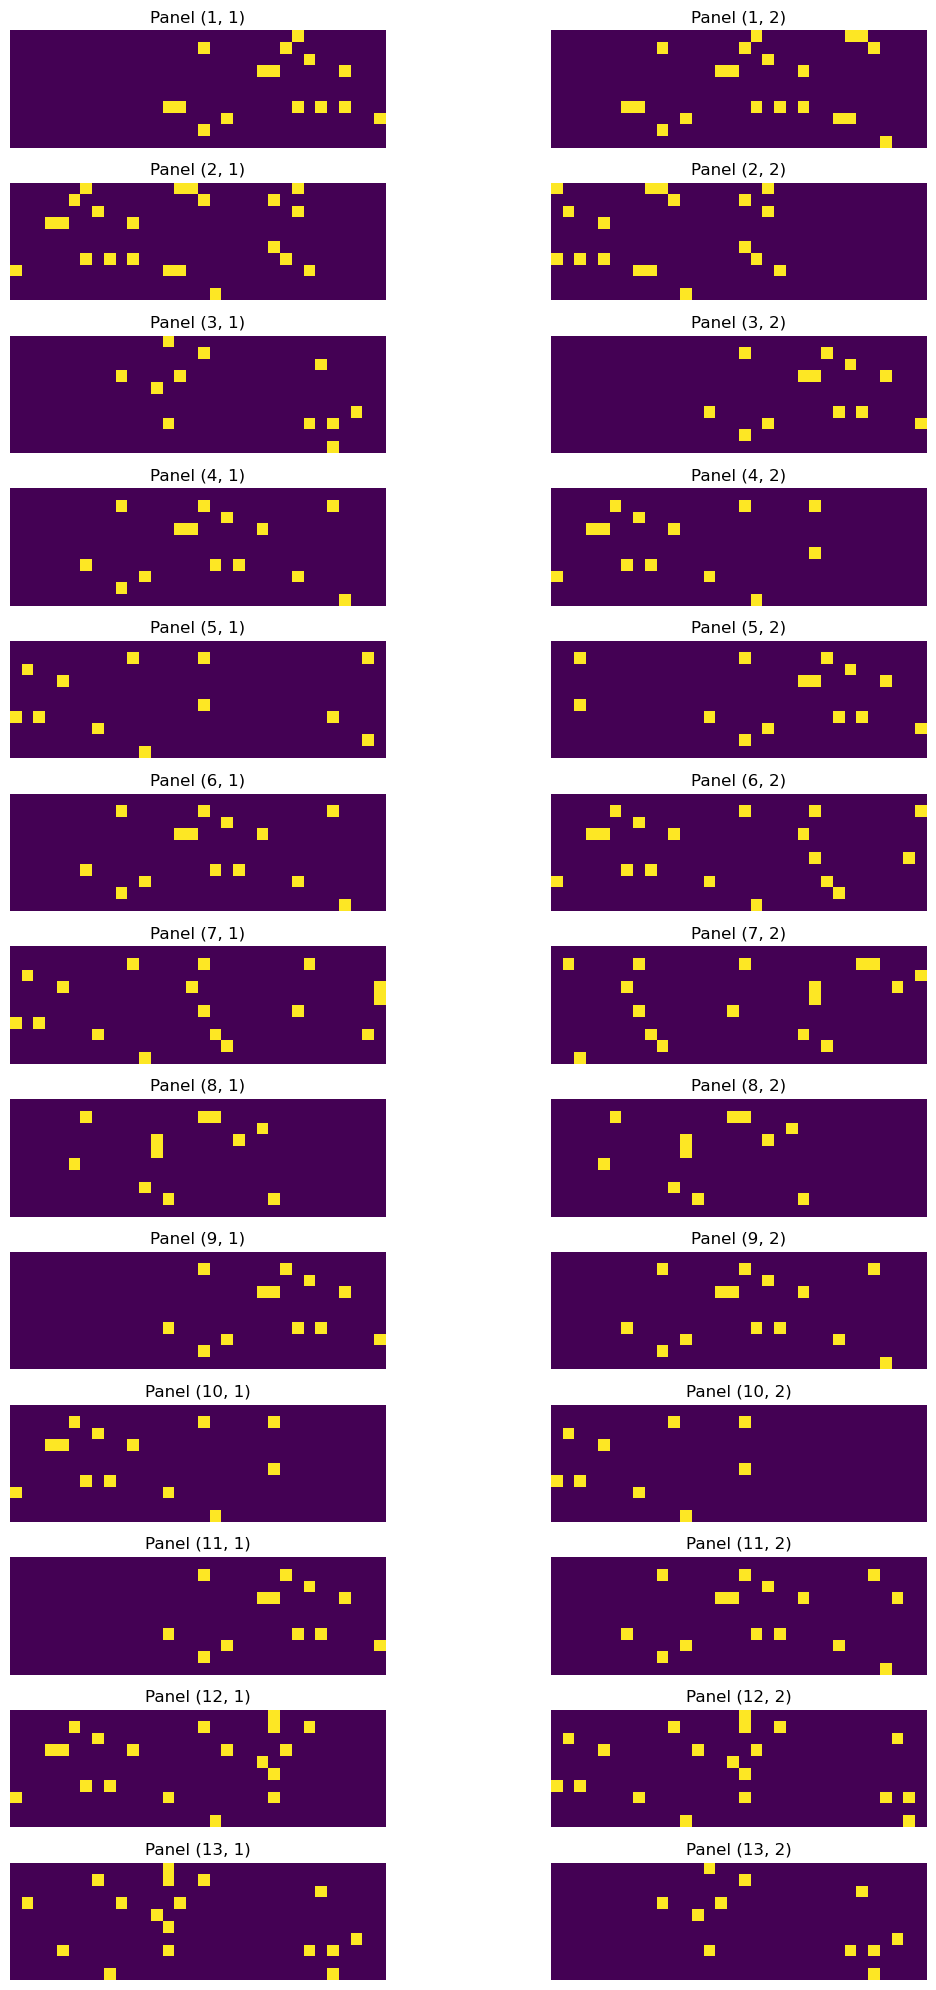

In [161]:
# Create a 2x4 grid of subplots
fig, axes = plt.subplots(13, 2, figsize=(12, 20))

# Loop through each subplot and create a dummy imshow plot
for i in range(13):
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(test[i,j])
        ax.set_title(f'Panel ({i+1}, {j+1})')
        ax.axis('off')  # Turn off axis labels and ticks

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

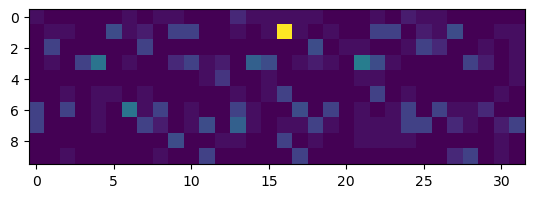

In [162]:
test = windows[N_labels==example]
plt.figure()
plt.imshow(np.sum(test,axis=0))

It's a lot harder to decipher the patterns embedded in the windows now even though we chose a neuron that responds to just 1 more spiking motif...
This is due to the multiple spikes per pattern that Neuron 1 expresses. The "window method" clusters the spikes according to their local neighborhood, and is not translation invariant because it is not a convolution, but a simple dot product. This means that if Neuron 1 spikes 4 times in response to Spiking Motif 1, the window method will detect 4 clusters.

Knowing this, we expect a number of clusters that reflects this.
- 4 spikes for motif 1
- 1 spike for motif 2
- 3 spike sfor motif 3

4 + 1 + 3 = 8 expected clusters

In [163]:
if len(test) > 0:
    x = np.zeros((len(test),len(test)))
    for i in range(test.shape[0]):
        for j in range(test.shape[0]):
            x[i,j] = np.sum(test[i]*test[j])/ min(np.sum(test[i]),np.sum(test[j]))
    similarity = x
    dissimilarity = 1 - x
    clusters_test = list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))

C:\Users\miles\AppData\Local\Temp\ipykernel_1676\2732013442.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters_test = list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))


Text(0, 0.5, 'Spikes (0,...,26) for Neuron 1')

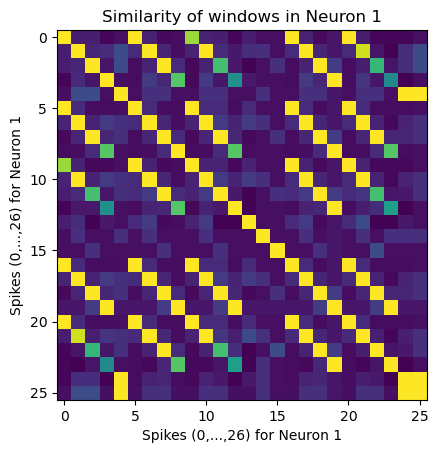

In [165]:
plt.figure()
plt.imshow(similarity)
plt.title('Similarity of windows in Neuron 1')
plt.xlabel('Spikes (0,...,26) for Neuron 1')
plt.ylabel('Spikes (0,...,26) for Neuron 1')

C:\Users\miles\AppData\Local\Temp\ipykernel_1676\4121898896.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDP = linkage(dissimilarity, method='complete')


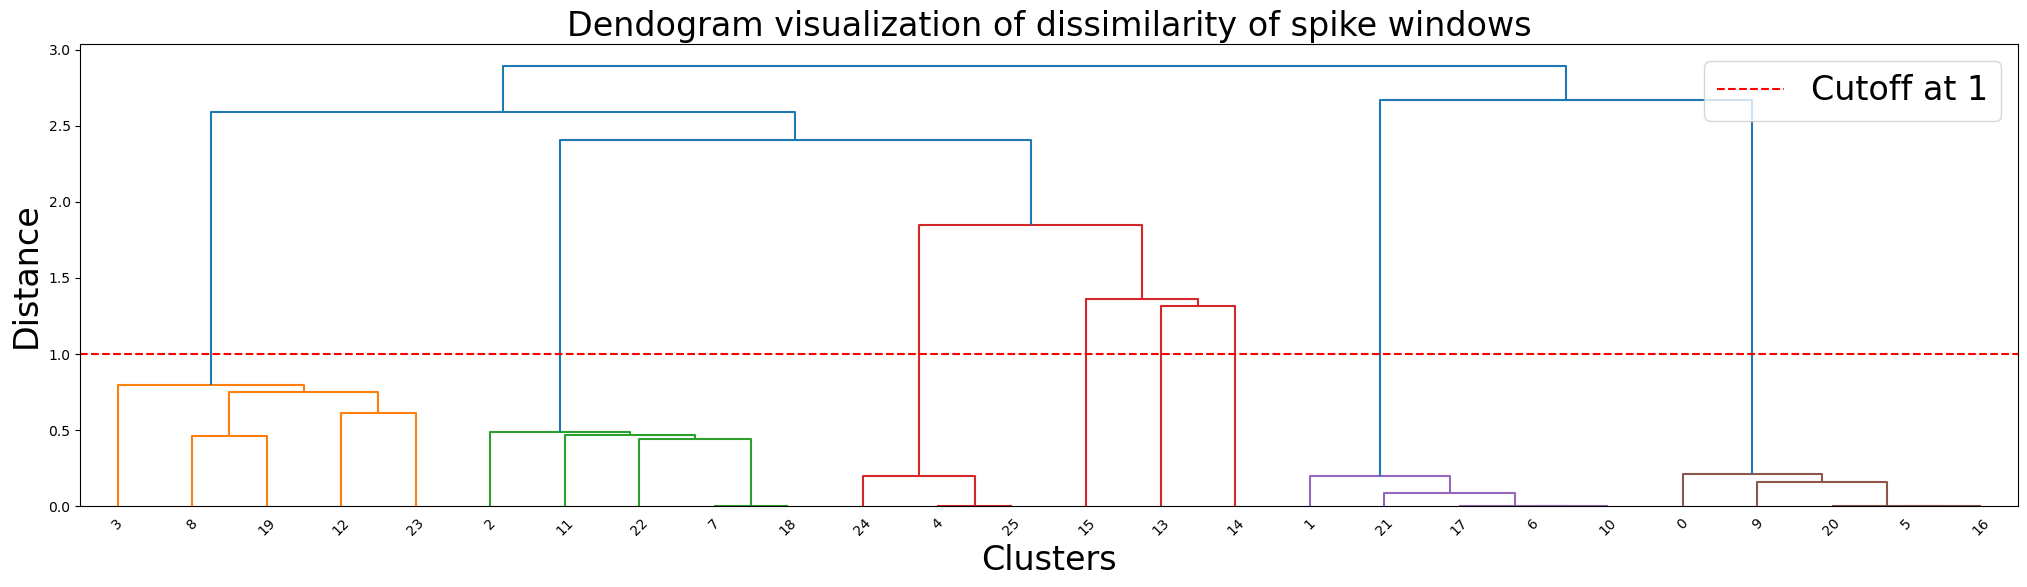

In [171]:
# Create the dendrogram plot
fig = plt.figure(figsize=(25, 6))
HDP = linkage(dissimilarity, method='complete')
dn = dendrogram(HDP)

# Add a horizontal line at the cutoff value of 1
plt.axhline(y=1, color='r', linestyle='--', label='Cutoff at 1')

# Add labels and legend
plt.title("Dendogram visualization of dissimilarity of spike windows", fontsize=24)
plt.ylabel('Distance', fontsize=24)
plt.xlabel('Clusters', fontsize=24)
plt.legend(fontsize=24)

plt.show()

In [179]:
print(fcluster(HDP, 1, criterion='distance'))

[8 7 2 1 3 8 7 2 1 8 7 2 1 4 5 6 8 7 2 1 8 7 2 1 3 3]


We get 8 clusters like we expected to with this method. More clustering needs to be done to get to the 3 clusters that we want...

Let's visualize the raster plot with the new cluster labels.
Upper panel is the ground truth.
Lower panel is the re-labeled with predicted clsuters

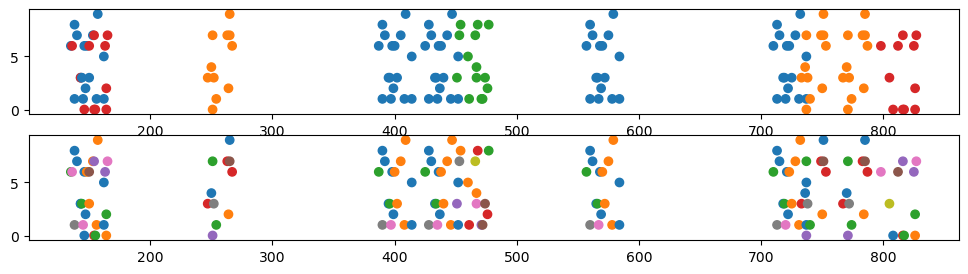

In [190]:
fig,ax = plt.subplot_mosaic('A;B',figsize=(12,3))
ax['A'].scatter(A_sparse[1],A_sparse[0],c=palette[A_sparse[2]])
ax['B'].scatter(A_sparse[1],A_sparse[0],c=palette[clusters%100])
plt.show()

Let's simplify this by just looking at how a single spiking motif was clustered...
Upper panel is the ground-truth, and the lower panel is the same plot with the predicted labels

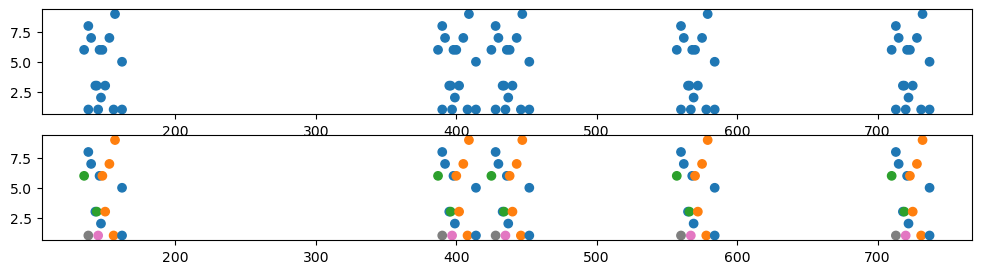

In [191]:
fig,ax = plt.subplot_mosaic('A;B',figsize=(12,3))
ax['A'].scatter(A_sparse[1][A_sparse[2]==1],A_sparse[0][A_sparse[2]==1],c=palette[A_sparse[2][A_sparse[2]==1]])
ax['B'].scatter(A_sparse[1][A_sparse[2]==1],A_sparse[0][A_sparse[2]==1],c=palette[clusters%100][A_sparse[2]==1])
plt.show()

Now it's clear that although the SM's in the bottom panel have different cluster labels, there respective labels make up a robust pattern that is repeated for each appearance of the pattern

Let's break it down even further...

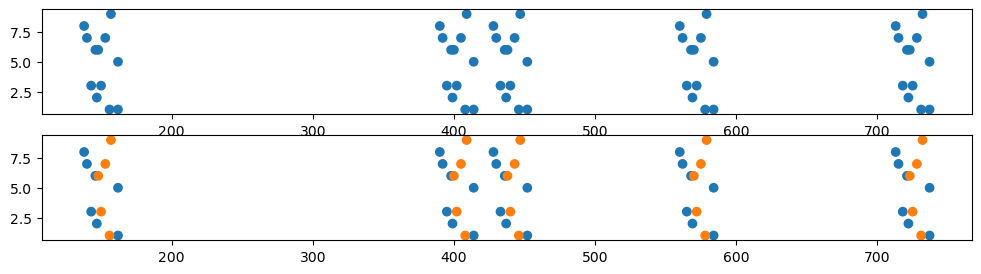

In [244]:
fig,ax = plt.subplot_mosaic('A;B',figsize=(12,3))
isis=[]
for i in range(3):
    x = A_sparse[1][clusters%100==i][A_sparse[2][clusters%100==i]==1]
    y = A_sparse[0][clusters%100==i][A_sparse[2][clusters%100==i]==1]
    ax['A'].scatter(x,y,c=palette[A_sparse[2][clusters%100==i][A_sparse[2][clusters%100==i]==1]])
    ax['B'].scatter(x,y,c=palette[clusters[clusters%100==i][A_sparse[2][clusters%100==i]==1]%100])
    isis.append(np.diff(x))
plt.show()

Even though these spikes have different cluser labels, if we look at the isi's filtered by label type, we see that they share very similar isis. This makes sense a priori since they correlate with the timings of the patterns.

In [245]:
isis

[array([], dtype=int64),
 array([ 252,   38,  132,  153, -590,  252,   38,  132,  153, -579,  252,
          38,  132,  153, -556,  252,   38,  132,  153, -591,  252,   38,
         132,  153, -581,  252,   38,  132,  153, -577,  252,   38,  132,
         153], dtype=int64),
 array([ 252,   38,  132,  153, -581,  252,   38,  132,  153, -577,  252,
          38,  132,  153, -570,  252,   38,  132,  153, -571,  252,   38,
         132,  153], dtype=int64)]

In Clusters 2, spikes get re-clustered by their filtered-ISI's

## Clustering 2

In [246]:
time_differences = []
cluster_sq = {}
for cluster in np.unique(clusters):
    time_differences.append(list(np.diff(A_trunc[1][clusters == cluster])))
    if str(list(np.diff(A_trunc[1][clusters == cluster]))) in cluster_sq.keys():
        cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] + [cluster]
    else: 
        cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = [cluster]
        
''' 
This is the second round of clustering. Only patterns that repeat across multiple neurons are considered a motif. 


with some help from chatgpt
'''

from collections import Counter

# Convert the list of lists to a set of tuples to remove duplicates
unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

# Convert the set of tuples back to a list of lists
unique_sublists = [list(sublist) for sublist in unique_sublists_set]

# Count the occurrences of each unique sublist in the original list
sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

# Print the unique sublists and their respective counts
for sublist in unique_sublists:
    count = sublist_counts[tuple(sublist)]
    print(f"{sublist}: {count} occurrences")

sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron

''' to visualize the clusters'''

recovered_labels = np.zeros_like(clusters)
for l, key in enumerate(sublist_keys_filt):
    for k in cluster_sq[str(key)]:
        recovered_labels[clusters == k] = l+1

''' to get the timings'''

# Sort y according to x
sorted_indices = np.argsort(A_trunc[1])
sorted_x = A_trunc[1][sorted_indices]

all_times = []
all_labels = []
for key in sublist_keys_filt:
    pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
    for i,k in enumerate(cluster_sq[str(key)]):
        pattern_repetition_labels[i][clusters==k] = 1
        pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
    pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
    all_labels.append(pattern_repetition_labels)
    
    sorted_y = pattern_repetition_labels[sorted_indices]
    pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
    all_times.append(pattern_times)


[0, 252, 38, 132, 153]: 1 occurrences
[662]: 10 occurrences
[486, 34]: 11 occurrences
[252, 38, 132, 153]: 15 occurrences


In [253]:
recovered_labels

array([1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 2, 3, 3, 0, 3,
       3, 2, 2, 1, 0, 0, 3, 3, 2, 2, 0, 3, 3, 0, 3, 3, 0, 0, 0, 0, 3, 3,
       0, 3, 3, 2, 2, 2, 2, 0, 2, 0, 2, 2, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3,
       1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 3, 3,
       1, 1, 2, 2, 2, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1,
       1, 3, 3, 3, 0, 0, 0, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2])

Here we see the how many occurences of certain ISI fingerprints exist in the predicted label data.

In [254]:
'''
Mapping Cluster Labels for Visualization
'''

from scipy.optimize import linear_sum_assignment

labels_array_1 = recovered_labels
labels_array_2 = A_trunc[2]

# Get unique labels from both arrays
unique_labels_1 = np.unique(labels_array_1)
unique_labels_2 = np.unique(labels_array_2)

# Create a cost matrix where each entry represents the cost of matching two labels
cost_matrix = np.zeros((len(unique_labels_1), len(unique_labels_2)))

for i, label_1 in enumerate(unique_labels_1):
    for j, label_2 in enumerate(unique_labels_2):
        common_elements = np.logical_and(labels_array_1 == label_1, labels_array_2 == label_2)
        cost_matrix[i, j] = -np.sum(common_elements)

# Use the Hungarian algorithm to find the optimal mapping
row_indices, col_indices = linear_sum_assignment(cost_matrix)

# Create a dictionary to store the many-to-one mapping
mapping_dict = {}

# Populate the mapping dictionary with the optimal mapping
for i, j in zip(row_indices, col_indices):
    label_1 = unique_labels_1[i]
    label_2 = unique_labels_2[j]
    
    if label_1 in mapping_dict:
        mapping_dict[label_1].append(label_2)
    else:
        mapping_dict[label_1] = [label_2]

# Find unmatched labels from labels_array_1
unmatched_labels_1 = np.setdiff1d(unique_labels_1, list(mapping_dict.keys()))

# Handle unmatched labels by assigning them to the closest label in labels_array_2
for label_1 in unmatched_labels_1:
    closest_label_2 = unique_labels_2[np.argmin(cost_matrix[label_1, :])]
    mapping_dict[label_1] = [closest_label_2]

# Map the labels from labels_array_1 to labels_array_2 using the mapping dictionary
# Use the get method with a default value of -1 for labels without a mapping
mapped_labels = np.array([mapping_dict[label] for label in labels_array_1]).squeeze()



We use a cost matrix to see which predicted labels map best to the ground-truth labels.
Here is the map:

In [257]:
mapping_dict

{0: [3], 1: [4], 2: [2], 3: [1]}

Now let's compare the predicted labels to the ground truth!

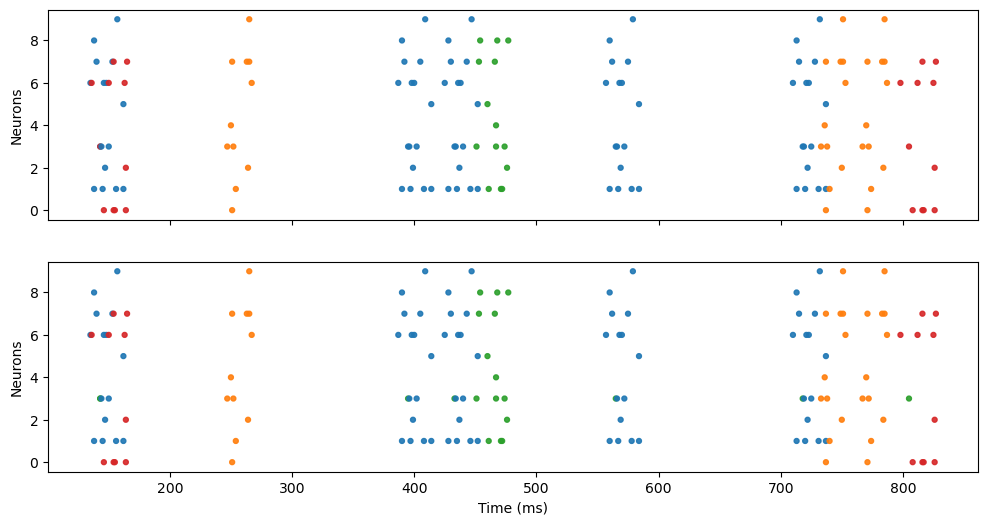

In [259]:
%matplotlib inline

sort_criteria_1 = mapped_labels
sort_criteria_2 = mapped_labels

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot data on the first subplot (ax1)
scatter1 = ax1.scatter(A_trunc[1][A_trunc[2]==0], A_trunc[0][A_trunc[2]==0], c=palette[A_trunc[2][A_trunc[2]==0]], alpha=0.9, s=50, marker='.')
scatter1 = ax1.scatter(A_trunc[1][A_trunc[2]!=0], A_trunc[0][A_trunc[2]!=0], c=palette[A_trunc[2][A_trunc[2]!=0]], alpha=0.9, s=50, marker='.')
ax1.set_ylabel('Neurons')

# Plot data on the second subplot (ax2)
scatter2 = ax2.scatter(A_trunc[1], A_trunc[0], c=palette[sort_criteria_1], alpha=0.9, s=50, marker='.')
ax2.set_ylabel('Neurons')
ax2.set_xlabel('Time (ms)')

# Show the plots
plt.show()


This performance metric measures the number of spikes that were correctly labeled:
- True positive corresponds to correctly labeled spiking motif spikes
- True negative correspondes to correctly labeled non SM spikes

In [261]:
'''
Performance
'''

TP = 0
TN = 0
total_TP = 0
total_TN = 0
for m in range(M):
    TP += np.sum(((A_trunc[2]==m) & (mapped_labels==m)) == True)
    TN += np.sum(((A_trunc[2]!=m) & (mapped_labels!=m)) == True)
    total_TP += np.sum(A_trunc[2]==m)
    total_TN += np.sum(A_trunc[2]!=m)
    
print("true positive, true negative, total_tp, total tn")
print(TP/total_TP, TN/total_TN, total_TP,total_TN)

true positive, true negative, total_tp, total tn
0.9606299212598425 0.9850746268656716 127 469


In [265]:
SMs = []
for sm_times in all_times:
    

3

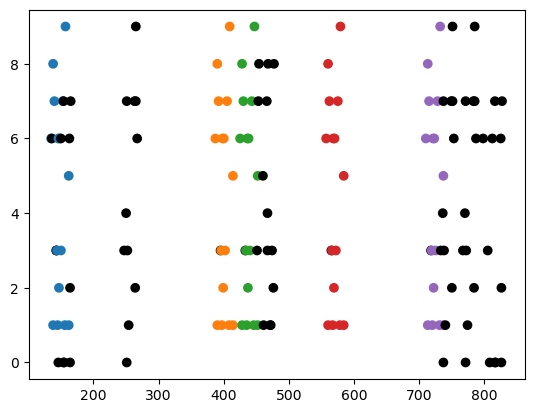

In [272]:
plt.figure()
plt.scatter(A_sparse[1],A_sparse[0],c=palette[pattern_repetition_labels])
plt.show()

In [263]:
all_times

[array([136, 798], dtype=int64),
 array([247, 733, 767], dtype=int64),
 array([135, 387, 425, 557, 710], dtype=int64)]